                                Simplilearn Youtube video part 2
Keras Tutorial For Beginners | Keras For Deep Learning | Deep Learning Tutorial | Simplilearn

https://www.youtube.com/watch?v=pWp3PhYI-OU&t=2600s

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL

In [2]:
# !pip install imutils

In [3]:
# initialize the initial learning rate, number of epochs to train for, and batch size

INIT_LR = 1e-4
EPOCHS = 2
BS = 32
DIRECTORY = 'facemask'
# DIRECTORY = r'C:\Users\Anthony\Desktop\Education\LiveClasses\DeepLearningKandTF\facemask'

In [4]:
data = []
labels = []

for category in os.listdir(DIRECTORY):
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)
print(labels[:10])

['without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask']


In [5]:
# perform one-hot encoding on the labels

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
# 0 for having a mask, 1 for without mask

print(labels[:10])
print(" ")
print(labels[-10:])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [8]:
# construct the training image generator for data augmentation

aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [9]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off

baseModel = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

C:\Users\Anthony\anaconda3\envs\py36_02\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [10]:
# construct the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
# place the head FC model on top of the base model (this will become the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# loop over all layers in the base model and freeze them so they will NOT update during the first training process

for layer in baseModel.layers:
    layer.trainable = False

In [13]:
# compile our model

print ("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [14]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
              steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),
              validation_steps=len(testX)  // BS,
              epochs=EPOCHS)

[INFO] training head...
  ...
    to  
  ['...']
Train for 37 steps, validate on 302 samples
Epoch 1/2
37/37 [==============================] - 141s 4s/step - loss: 0.7709 - accuracy: 0.5703 - val_loss: 0.3080 - val_accuracy: 0.8958
Epoch 2/2
37/37 [==============================] - 147s 4s/step - loss: 0.4155 - accuracy: 0.8150 - val_loss: 0.1791 - val_accuracy: 0.9618


In [15]:
# make predictions on the testing set

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [16]:
# for each image in the testing set, we need to find the index of the label
# with corresponding largest predicted probability

predIdxs = np.argmax(predIdxs, axis=1)

#show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.94      0.98      0.96       151
without_mask       0.98      0.94      0.96       151

    accuracy                           0.96       302
   macro avg       0.96      0.96      0.96       302
weighted avg       0.96      0.96      0.96       302



In [17]:
# serialize the model to disk

print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


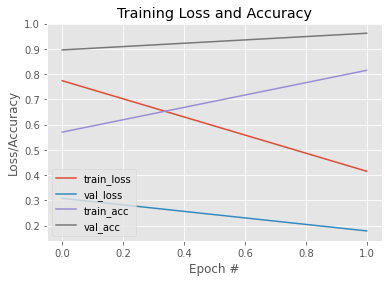

In [18]:
# plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")